<a href="https://colab.research.google.com/github/jiaminho/RPH-HAC-Prediction/blob/main/HAC_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hospital Acquired Complications (HACs) Model Training and Evaluation

Install and import libraries

In [22]:
# Installing Packages
!pip install umap-learn
!pip install bokeh
!pip install bokeh holoviews colorcet scikit-image datashader
!pip install shap

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx
import os
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
from keras.layers import Input, Dense
from keras.models import Model
import numpy as np
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.utils.class_weight import compute_sample_weight
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, auc
import shap
import umap
import umap.plot
from sklearn.cluster import AgglomerativeClustering
from collections import Counter
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score



from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
pd.set_option('display.max_columns', None)  # None ensures all columns are shown
warnings.simplefilter(action='ignore', category=FutureWarning)

Read pre-processed data "all_encoded_df"

In [24]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download the file
file_id = '1n3-DE1LS2En9Pj8hlWpnLho2_pZk5M9t'
file_name = 'selected_features_150.csv'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(file_name)

# Read into DataFrame
selected_features_df = pd.read_csv(file_name)
selected_features_df.shape

(58976, 151)

In [25]:
selected_features_df.head()

,"Cholesterol, Total",Procedure: Aspiration and Organ Repair,corynebacterium sp diphtheroids,"Total Protein, CSF",DIAGNOSIS_ALTERED MENTAL STATUS,DIAGNOSIS_CONGESTIVE HEART FAILURE,Troponin I,DIAGNOSIS_URINARY TRACT INFECTION;PYELONEPHRITIS,"RBC, CSF",Uric Acid,Procedure: Pancreatic and Bronchial Interventions,Ethanol,clostridium difficile,Procedure: Joint Dislocation and Hand Surgery,HAS_CHARTEVENTS_DATA,R,Polys,Procedure: Cardiac Repair and Hernia Procedures,Procedure: Plastic Surgery and Duct Procedures,"Reticulocyte Count, Automated",Procedure: Head and Device Insertion,Procedure: Trachea and Abdominal Procedures,Digoxin,D-Dimer,Protein/Creatinine Ratio,Sedimentation Rate,Procedure: Digestive and Diaphragm Procedures,"Protein, Total",Procedure: Large Intestine and Bone Surgery,DIAGNOSIS_PNEUMONIA,Vitamin B12,"Osmolality, Measured","Calculated Bicarbonate, Whole Blood",Procedure: Tissue Reconstruction and Catheterization,Procedure: Foreign Body Removal and Graft,Procedure: Intestinal Stoma and Manipulation,Procedure: Intestinal Transfer and Surgery,CK-MB Index,2nd isolate,Triglycerides,Procedure: Tendon and Obstetric Procedures,Myelocytes,Procedure: Renal and Thyroid Interventions,C-Reactive Protein,Procedure: Vessel Anastomosis and Resection,Specific Gravity,"Bilirubin, Direct",Nucleated Red Cells,Granular Casts,Procedure: Electrode and Vascular Implantation,Procedure: Limb Exploration and Surgery,Procedure: Fibula and Sinus Procedures,Procedure: Dilation and Urethral Procedures,Haptoglobin,Procedure: Diagnostic and Device Implantation,Metamyelocytes,ETHNICITY_UNKNOWN/NOT SPECIFIED,Phenytoin,gram pos bacteria,Hemoglobin,Procedure: Closure and Chest Procedures,Amylase,Procedure: Lesion Excision and Soft Tissue Surgery,Atypical Lymphocytes,% Hemoglobin A1c,Cortisol,Hematocrit,Bands,Thyroid Stimulating Hormone,Iron,Procedure: Surgical Suture and Repair,Lipase,Ferritin,ETHNICITY_BLACK/AFRICAN AMERICAN,NTproBNP,"Creatine Kinase, MB Isoenzyme",Eosinophils,"Iron Binding Capacity, Total",Procedure: Cranial and Peripheral Interventions,"Chloride, Whole Blood","Sodium, Whole Blood",Procedure: Facial and Thoracic Surgery,"Fibrinogen, Functional","Bilirubin, Total",Procedure: Gastric Procedure and Vascular Revision,Transferrin,Monocytes,ADMISSION_TYPE_ELECTIVE,Procedure: Spinal and Abdominal Surgery,Procedure: Structural and Bone Biopsy,Alanine Aminotransferase (ALT),Procedure: Lung Biopsy and Intervention,S,ADMISSION_LOCATION_TRANSFER FROM HOSP/EXTRAM,ADMISSION_LOCATION_CLINIC REFERRAL/PREMATURE,Procedure: External Device and Eyelid Repair,"Potassium, Whole Blood",Urobilinogen,pCO2,Lactate Dehydrogenase (LD),Calculated Total CO2,Free Calcium,Asparate Aminotransferase (AST),pO2,ETHNICITY_WHITE,Procedure: Arterial Imaging and Debridement,Anion Gap,ADMISSION_TYPE_NEWBORN,pH,Glucose,MCV,Alkaline Phosphatase,DIAGNOSIS_NEWBORN,Red Blood Cells,Lactate,Platelet Count,Procedure: Knee and Spinal Surgery,ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI,MCH,Hyaline Casts,White Blood Cells,ADMISSION_LOCATION_EMERGENCY ROOM ADMIT,MCHC,RDW,Neutrophils,Magnesium,Procedure: Injections and Therapeutic Procedures,Phosphate,PTT,Lymphocytes,Creatine Kinase (CK),INR(PT),Bicarbonate,PT,Procedure: Contrast Imaging and Spleen Procedures,Procedure: Catheterization and Ventilation Techniques,Chloride,Troponin T,Creatinine,ADMISSION_TYPE_EMERGENCY,"Calcium, Total",Potassium,Sodium,GENDER_M,Albumin,GENDER_F,Urea Nitrogen,RBC,AGE_AT_ADMISSION,WBC,uti
0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0,1.0,0.0,1.0,0.0,3.0,0,0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1,0.0,1.0,0,1.0,1.0,1.0,1.0,0,1.0,1.0,1.0,1.0,0,1.0,0.0,1.0,1,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.

In [26]:
selected_features_df['uti'] = selected_features_df['uti'].replace({True: 1, False: 0})

train test split

In [27]:
X = selected_features_df.drop('uti', axis=1)
y = selected_features_df['uti']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
# Scale data
scaler_original = StandardScaler()
X_train_scaled = scaler_original.fit_transform(X_train)
X_test_scaled = scaler_original.transform(X_test)

train val split

In [29]:
X_train_scaled, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

### DNN (Shiv)

In [30]:
dims = 150

X_train_scaled_new = X_train_scaled[:,:dims]
X_val_new = X_val[:,:dims]
X_test_scaled_new = X_test_scaled[:,:dims]

In [31]:
inp = Input(shape=[dims,])
out = inp

# Compute sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Performance Scheduling
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

# early stopping
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)


for ix in range(3):
  out = Dense(64,activation='swish')(out)
  out = Dropout(0.2)(out)
out_encoder = Dense(64)(out)
out = Dense(1,activation='sigmoid')(out)
model = Model(inp,out)
model_encoder = Model(inp,out_encoder)
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
history = model.fit(X_train_scaled_new, y_train, epochs=100, batch_size=64, validation_data=(X_val_new, y_val),sample_weight=sample_weights,
                   callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
590/590 [==============================] - 4s 4ms/step - loss: 0.4993 - accuracy: 0.7257 - val_loss: 0.4419 - val_accuracy: 0.7801 - lr: 0.0010
Epoch 2/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4449 - accuracy: 0.7668 - val_loss: 0.4700 - val_accuracy: 0.7671 - lr: 0.0010
Epoch 3/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4335 - accuracy: 0.7713 - val_loss: 0.4189 - val_accuracy: 0.7910 - lr: 0.0010
Epoch 4/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4215 - accuracy: 0.7737 - val_loss: 0.4158 - val_accuracy: 0.7906 - lr: 0.0010
Epoch 5/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4090 - accuracy: 0.7820 - val_loss: 0.4267 - val_accuracy: 0.7811 - lr: 0.0010
Epoch 6/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4005 - accuracy: 0.7848 - val_loss: 0.4096 - val_accuracy: 0.7865 - lr: 0.0010
Epoch 7/100
590/590 [==============================] - 3s 4ms/st

In [32]:
# train and test predictions
dnn_y_test_pred = model.predict(X_test_scaled_new)
dnn_y_train_pred = model.predict(X_train_scaled_new)
print(classification_report(y_test, dnn_y_test_pred.round()))

1180/1180 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

         0.0       0.96      0.83      0.89     10463
         1.0       0.35      0.75      0.48      1333

    accuracy                           0.82     11796
   macro avg       0.66      0.79      0.68     11796
weighted avg       0.89      0.82      0.84     11796



In [33]:
# calculate balanced accuracy
print(f"{balanced_accuracy_score(y_test, dnn_y_test_pred.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, dnn_y_train_pred.round()) * 100:.2f}% - Balanced accuracy Train")

78.69% - Balanced accuracy Test
86.16% - Balanced accuracy Train


#### UMAP and Agglomerative clustering

- Use a pre-trained model encoder to transform the training and testing data (X_train_scaled_new and X_test_scaled_new).
- Apply UMAP (Uniform Manifold Approximation and Projection) dimensionality reduction to the encoded test data.
- Use agglomerative clustering on the encoded test data.
- Identify clusters that contain prediction errors and summarizes these errors.
- Visualize the data points in the 2D UMAP space, highlighting errors and true labels.

In [34]:
# Using a Pre-trained Model Encoder to Transform Data
Xenc_train = model_encoder(X_train_scaled_new).numpy()
Xenc_test = model_encoder(X_test_scaled_new)

# Applying UMAP Dimensionality Reduction
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(Xenc_test)

# Model Prediction
y_pred = model(X_test_scaled_new).numpy().round()

# Fitting UMAP to Test Data
mapper = umap.UMAP().fit(Xenc_test)

# Applying Agglomerative Clustering
cluster = AgglomerativeClustering(metric="cosine", distance_threshold=0.5, n_clusters=None, linkage='average')
cluster_test = cluster.fit_predict(Xenc_test.numpy())

# Identifying Errors
error = [cluster_test[ix] for ix in range(len(y_pred[:,0])) if (not y_pred[ix,0] == y_test.values[ix]) and  y_pred[ix,0] == 1]
print(Counter(cluster_test).most_common(10))
print(Counter(error).most_common(10))

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.


[(3, 7298), (50, 1011), (90, 621), (20, 426), (182, 364), (1, 289), (39, 114), (97, 74), (9, 70), (5, 70)]
[(50, 542), (90, 409), (182, 253), (97, 49), (9, 45), (173, 31), (103, 31), (39, 30), (8, 25), (72, 23)]


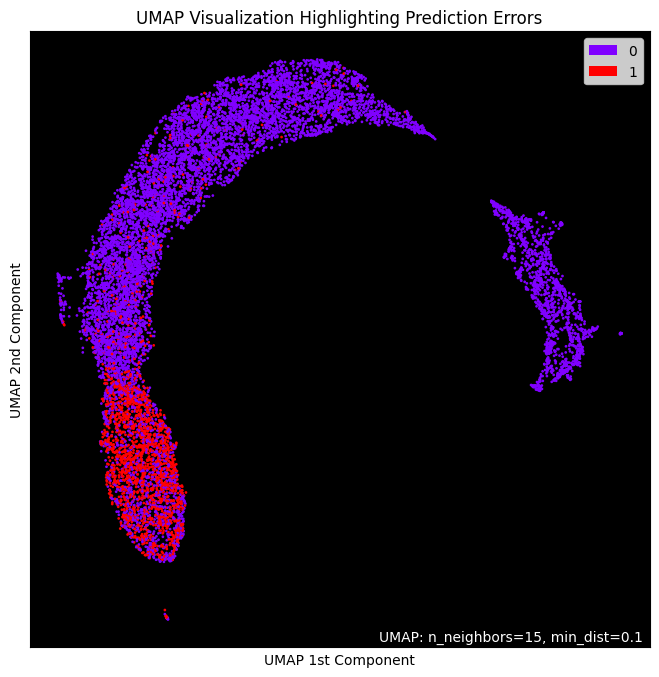

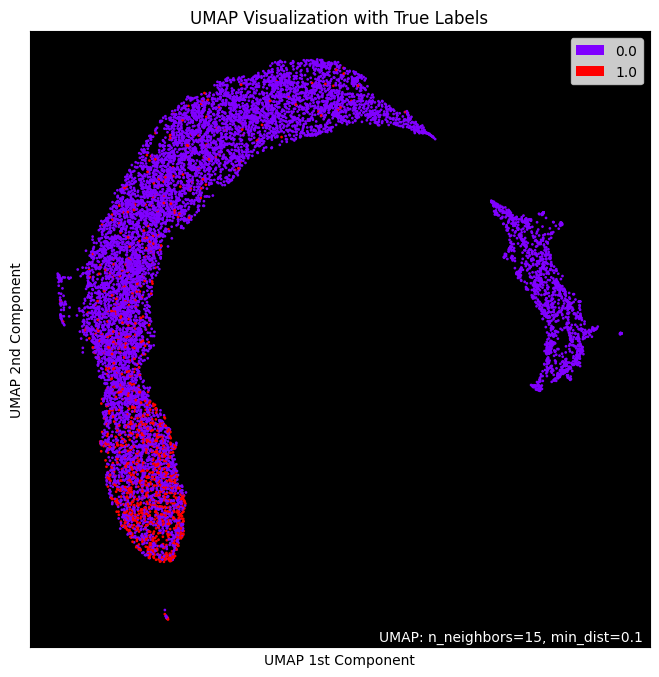

In [35]:
# Error and Label Lists
errors = [0 if y_pred[ix,0] == y_test.values[ix] else 1 for ix in range(len(y_pred[:,0]))]
labels = [y_test.values[ix] for ix in range(len(y_pred[:,0]))]

# Visualization using UMAP
umap.plot.points(mapper, labels=np.array(errors), theme='fire')
plt.gca().set_title('UMAP Visualization Highlighting Prediction Errors')
plt.xlabel('UMAP 1st Component')
plt.ylabel('UMAP 2nd Component')
plt.show()

umap.plot.points(mapper, labels=np.array(labels), theme='fire')
plt.gca().set_title('UMAP Visualization with True Labels')
plt.xlabel('UMAP 1st Component')
plt.ylabel('UMAP 2nd Component')
plt.show()

# # Scatter Plot for 2D UMAP Visualization
# x_coords = embedding[:, 0]
# y_coords = embedding[:, 1]
# plt.scatter(x_coords, y_coords, c=labels, cmap='jet', s=15, alpha=0.6, edgecolors='w')
# plt.xlabel('UMAP 1st component')
# plt.ylabel('UMAP 2nd component')
# plt.colorbar(label='Label')
# plt.title('2D UMAP Visualization with Labels')
# plt.show()

Permutation Importance

In [39]:
feature_names = X.columns.tolist()

In [ ]:
def permutation_importance(model, X_val_new, y_val, metric=accuracy_score):
    """
    Calculate permutation importance for a given model and validation set.

    Parameters:
    - model: Trained model
    - X_val: Validation data (features)
    - y_val: True labels for validation data
    - metric: Performance metric function

    Returns:
    - importances: Feature importance scores
    """
    feature_names = X.columns.tolist()

    # Get the original performance of the model
    original_preds = model.predict(X_val_new)
    # Convert predictions to binary values
    original_preds_binary = (original_preds > 0.5).astype(int)
    original_score = metric(y_val, original_preds_binary)

    # Calculate permutation importance for each feature
    importances = []
    for col in range(X_val_new.shape[1]):
        X_val_copy = X_val_new.copy()
        np.random.shuffle(X_val_copy[:, col])
        shuffled_preds = model.predict(X_val_copy, verbose=0)
        shuffled_preds_binary = (shuffled_preds > 0.5).astype(int)
        shuffled_score = metric(y_val, shuffled_preds_binary)
        importances.append(original_score - shuffled_score)

    return np.array(importances)

# Calculate permutation importance
feature_importances = permutation_importance(model, X_val_new, y_val)

# Display feature importances
for i, imp in enumerate(feature_importances):
    print(f"Feature {feature_names[i]}: {imp}")


In [46]:
def permutation_importance(model, X_val_new, y_val, metric=accuracy_score):
    """
    Calculate permutation importance for a given model and validation set.

    Parameters:
    - model: Trained model
    - X_val: Validation data (features)
    - y_val: True labels for validation data
    - metric: Performance metric function

    Returns:
    - importances: Feature importance scores
    """
    feature_names = X.columns.tolist()

    # Get the original performance of the model
    original_preds = model.predict(X_val_new)
    # Convert predictions to binary values
    original_preds_binary = (original_preds > 0.5).astype(int)
    original_score = metric(y_val, original_preds_binary)

    # Calculate permutation importance for each feature
    importances = []
    for col in range(X_val_new.shape[1]):
        X_val_copy = X_val_new.copy()
        np.random.shuffle(X_val_copy[:, col])
        shuffled_preds = model.predict(X_val_copy, verbose=0)
        shuffled_preds_binary = (shuffled_preds > 0.5).astype(int)
        shuffled_score = metric(y_val, shuffled_preds_binary)
        importances.append(original_score - shuffled_score)

    return np.array(importances)

# Calculate permutation importance
feature_importances = permutation_importance(model, X_val_new, y_val)

# Pair feature names with their importances
feature_importance_pairs = list(zip(feature_names, feature_importances))

# Sort feature importances in descending order
sorted_feature_importance_pairs = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

# Display feature importances in descending order
for name, imp in sorted_feature_importance_pairs:
    print(f"Feature {name}: {imp}")


295/295 [==============================] - 1s 2ms/step
Feature WBC: 0.042284866468842774
Feature S: 0.02342094107672743
Feature AGE_AT_ADMISSION: 0.004557015684612087
Feature Hyaline Casts: 0.003285290377278538
Feature Granular Casts: 0.003179313268334094
Feature ETHNICITY_UNKNOWN/NOT SPECIFIED: 0.0029673590504450953
Feature R: 0.0027554048325562075
Feature 2nd isolate: 0.0025434506146672087
Feature Asparate Aminotransferase (AST): 0.0024374735057227648
Feature Procedure: Knee and Spinal Surgery: 0.0024374735057227648
Feature C-Reactive Protein: 0.0019075879610004343
Feature RBC: 0.0019075879610004343
Feature gram pos bacteria: 0.0018016108520559904
Feature Metamyelocytes: 0.0015896566341669915
Feature Free Calcium: 0.0015896566341669915
Feature Bicarbonate: 0.0015896566341669915
Feature Potassium: 0.0015896566341669915
Feature ETHNICITY_BLACK/AFRICAN AMERICAN: 0.0014836795252225476
Feature ADMISSION_LOCATION_EMERGENCY ROOM ADMIT: 0.0014836795252225476
Feature Procedure: Injections and

## Deep Neural Network (DNN)

In [9]:
# Compute sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Performance Scheduling
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

# early stopping
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)


model = Sequential()
model.add(Dense(64, input_shape=(X_train_scaled.shape[1],), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=64, sample_weight=sample_weights, validation_data=(X_val, y_val),
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
590/590 [==============================] - 5s 4ms/step - loss: 0.5365 - accuracy: 0.6830 - val_loss: 0.4312 - val_accuracy: 0.7595 - lr: 0.0010
Epoch 2/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4611 - accuracy: 0.7424 - val_loss: 0.4154 - val_accuracy: 0.7762 - lr: 0.0010
Epoch 3/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4459 - accuracy: 0.7498 - val_loss: 0.3956 - val_accuracy: 0.7897 - lr: 0.0010
Epoch 4/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4313 - accuracy: 0.7591 - val_loss: 0.4300 - val_accuracy: 0.7705 - lr: 0.0010
Epoch 5/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4234 - accuracy: 0.7626 - val_loss: 0.3947 - val_accuracy: 0.7835 - lr: 0.0010
Epoch 6/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4138 - accuracy: 0.7666 - val_loss: 0.4003 - val_accuracy: 0.7845 - lr: 0.0010
Epoch 7/100
590/590 [==============================] - 2s 4ms/st

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                9664      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1

Plot Learning Curves

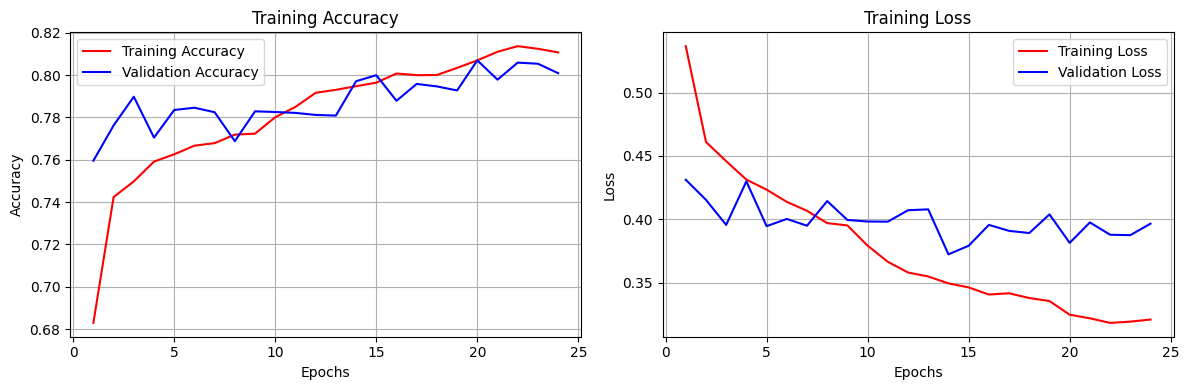

In [11]:
def plot_learning_curves(history):
    # Extract the training and validation losses & accuracies
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 4))

    # Plot training and validation accuracies
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot training and validation losses
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_learning_curves(history)

**DNN Model Evaluation**

In [12]:
# train and test predictions
dnn_y_test_pred = model.predict(X_test_scaled)
dnn_y_train_pred = model.predict(X_train_scaled)

1180/1180 [==============================] - 2s 1ms/step


In [13]:
print(classification_report(y_test, dnn_y_test_pred.round()))

              precision    recall  f1-score   support

         0.0       0.97      0.79      0.87     10463
         1.0       0.33      0.79      0.46      1333

    accuracy                           0.79     11796
   macro avg       0.65      0.79      0.67     11796
weighted avg       0.90      0.79      0.82     11796



In [14]:
# calculate balanced accuracy
print(f"{balanced_accuracy_score(y_test, dnn_y_test_pred.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, dnn_y_train_pred.round()) * 100:.2f}% - Balanced accuracy Train")

79.21% - Balanced accuracy Test
87.92% - Balanced accuracy Train


Text(33.22222222222222, 0.5, 'Actual')

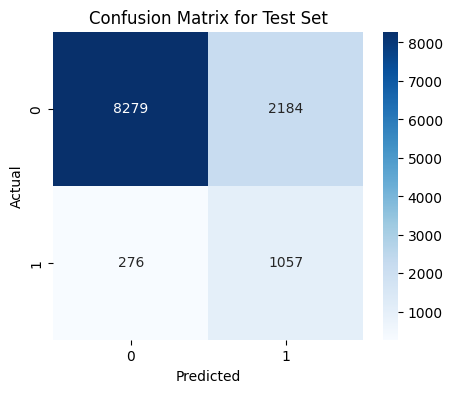

In [15]:
# define labels
labels = ['0', '1']

# confusion matrix
test_cm = confusion_matrix(y_test, dnn_y_test_pred.round())
#train_cm = confusion_matrix(y_train, dnn_y_train_pred.round())
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_title('Confusion Matrix for Test Set')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

369/369 [==============================] - 1s 1ms/step


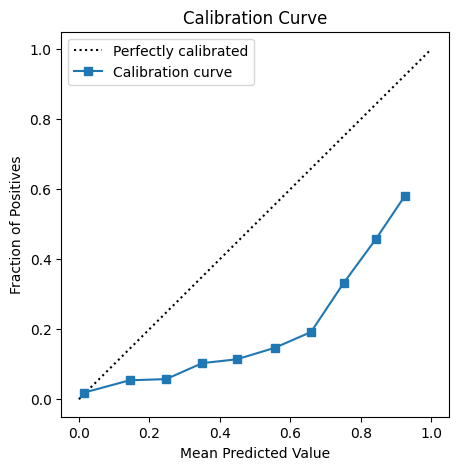

In [16]:
# calibration curve
# dnn_y_test_pred_proba = model.predict_proba(X_test_scaled)
# prob_true, prob_pred = calibration_curve(y_test, dnn_y_test_pred_proba, n_bins=10, strategy='uniform')

dnn_y_test_pred = model.predict(X_test_scaled)
prob_true, prob_pred = calibration_curve(y_test, dnn_y_test_pred, n_bins=10, strategy='uniform')

plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
plt.plot(prob_pred, prob_true, 's-', label='Calibration curve')
plt.ylabel('Fraction of Positives')
plt.xlabel('Mean Predicted Value')
plt.legend()
plt.title('Calibration Curve')
plt.show()

Perfectly Calibrated: In a perfectly calibrated model, the calibration curve would be a diagonal line, going from the bottom left corner to the top right corner of the plot (i.e., a 45-degree line, often labeled as "Perfectly calibrated").

Over-confident: If the curve is below the diagonal line, the model's predicted probabilities are generally higher than the actual fraction of positives, indicating over-confidence.

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


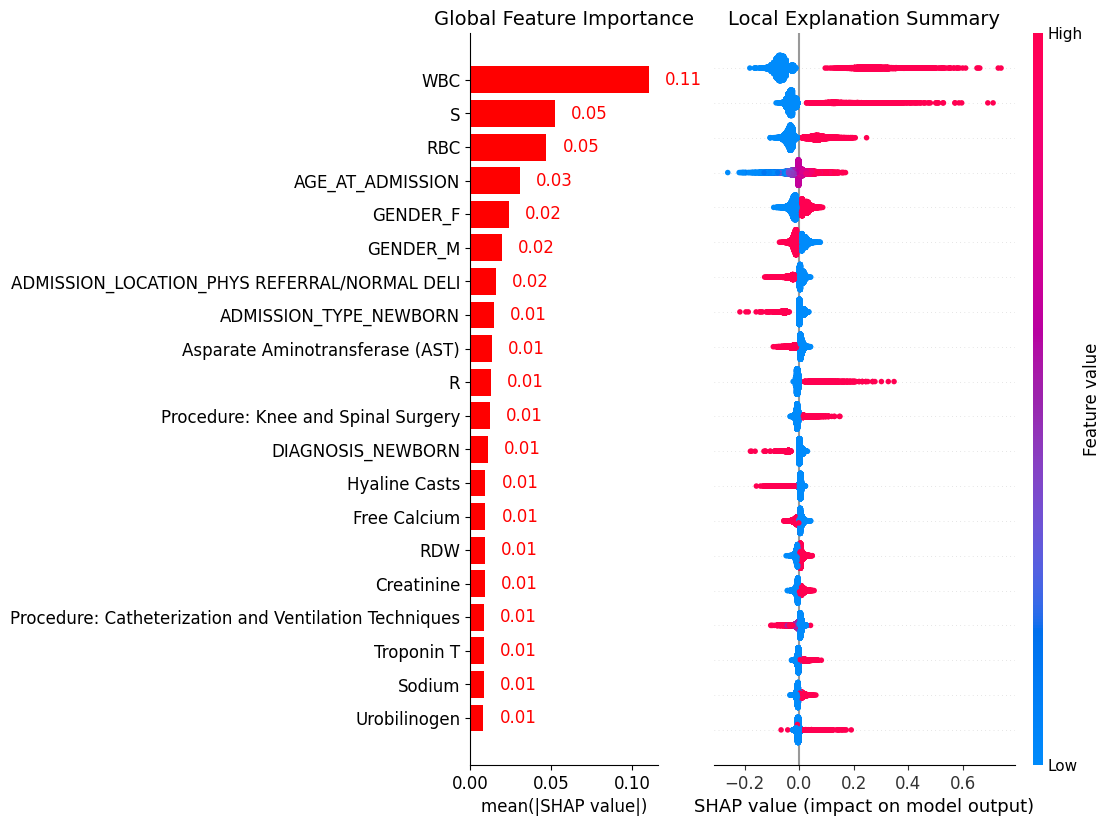

In [20]:
## SHAP

import matplotlib.gridspec as gridspec
import shap

# Get feature names
feature_names = X.columns.tolist()

X_train_scaled = X_train_scaled.astype(np.float32)
#subset_data = X_train_scaled[:1000]  # Taking a subset of 1000 samples
random_indices = np.random.choice(X_train_scaled.shape[0], size=1000, replace=False)
subset_data = X_train_scaled[random_indices]


# Compute SHAP values for a particular set (e.g., test set)
# Using DeepExplainer for Deep Neural Network model:
explainer = shap.DeepExplainer(model, subset_data)
shap_values = explainer.shap_values(X_test_scaled)

# The first set of values from the list of shap_values for binary classification
shap_values_array = shap_values[0]

# Calculate mean absolute SHAP values for global importance
global_shap_vals = np.abs(shap_values_array).mean(axis=0)

# Sort features based on their global importance
sorted_indices = np.argsort(global_shap_vals)[-20:]
top_features = np.array(feature_names)[sorted_indices]
top_global_shap_vals = global_shap_vals[sorted_indices]

# Subset the data and SHAP values for top features
top_shap_values = shap_values_array[:, sorted_indices]
X_test_top_features = X_test_scaled[:, sorted_indices]

# Create a combined plot with subplots using GridSpec for layout
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])

# Plot global importance of top features on left
ax1 = plt.subplot(gs[0])
bars = ax1.barh(top_features, top_global_shap_vals, color='red')
ax1.set_xlabel('mean(|SHAP value|)', fontsize=12)
ax1.set_title('Global Feature Importance', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# Add values beside the bar with red color
for bar in bars:
    ax1.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.2f}',
             va='center', ha='left', color='red', fontsize=12)

# Plot typical SHAP values on right
ax2 = plt.subplot(gs[1])
shap.summary_plot(top_shap_values, X_test_top_features, feature_names=top_features, plot_type="dot", show=False)
ax2.set_title('Local Explanation Summary', fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_yticks([])
ax2.set_yticklabels([])

plt.show()

## Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [20]:
rf_y_pred = rf.predict(X_test_scaled)
rf_y_train_pred = rf.predict(X_train_scaled)
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.99      0.94     10463
         1.0       0.65      0.08      0.14      1333

    accuracy                           0.89     11796
   macro avg       0.77      0.54      0.54     11796
weighted avg       0.87      0.89      0.85     11796



In [21]:
# calculate balanced accuracy
from sklearn.metrics import balanced_accuracy_score
print(f"{balanced_accuracy_score(y_test, rf_y_pred.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, rf_y_train_pred.round()) * 100:.2f}% - Balanced accuracy Train")

53.56% - Balanced accuracy Test
99.99% - Balanced accuracy Train


Text(33.22222222222222, 0.5, 'Actual')

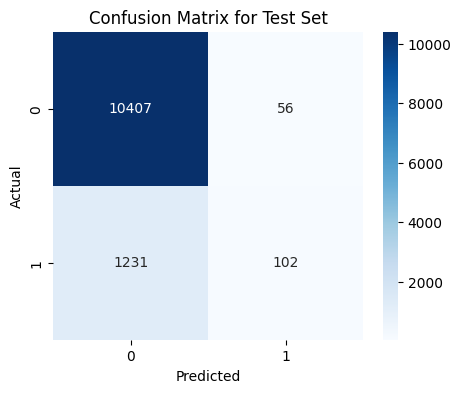

In [22]:
# define labels
labels = ['0', '1']

# confusion matrix
test_cm = confusion_matrix(y_test, rf_y_pred.round())
train_cm = confusion_matrix(y_train, rf_y_train_pred.round())
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_title('Confusion Matrix for Test Set')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

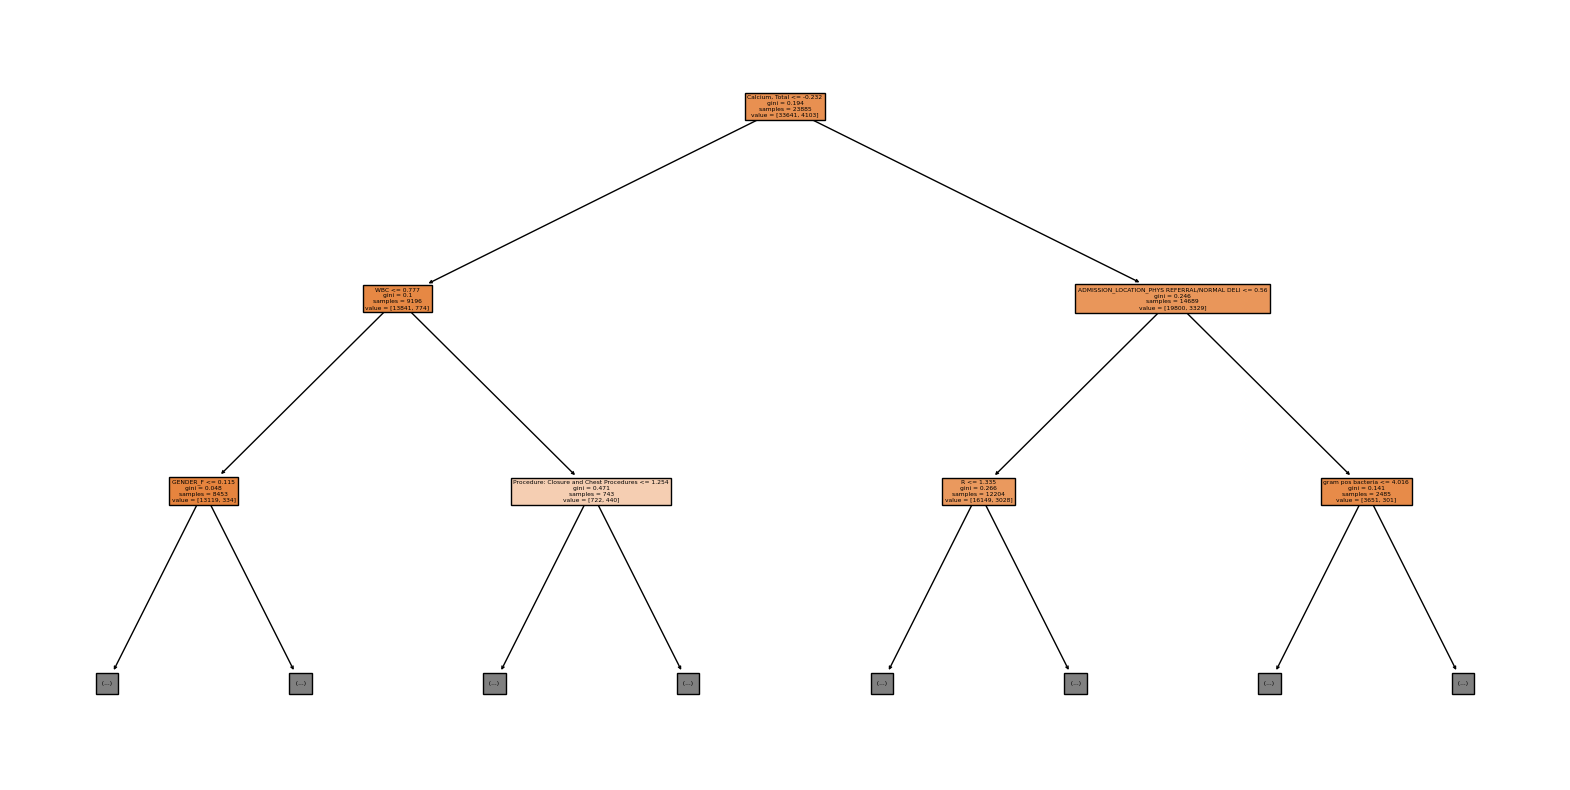

In [23]:
from sklearn.tree import plot_tree

# Visualizing the first decision tree
plt.figure(figsize=(20,10))
plot_tree(rf.estimators_[0], filled=True, max_depth=2, feature_names=X.columns)
plt.show()

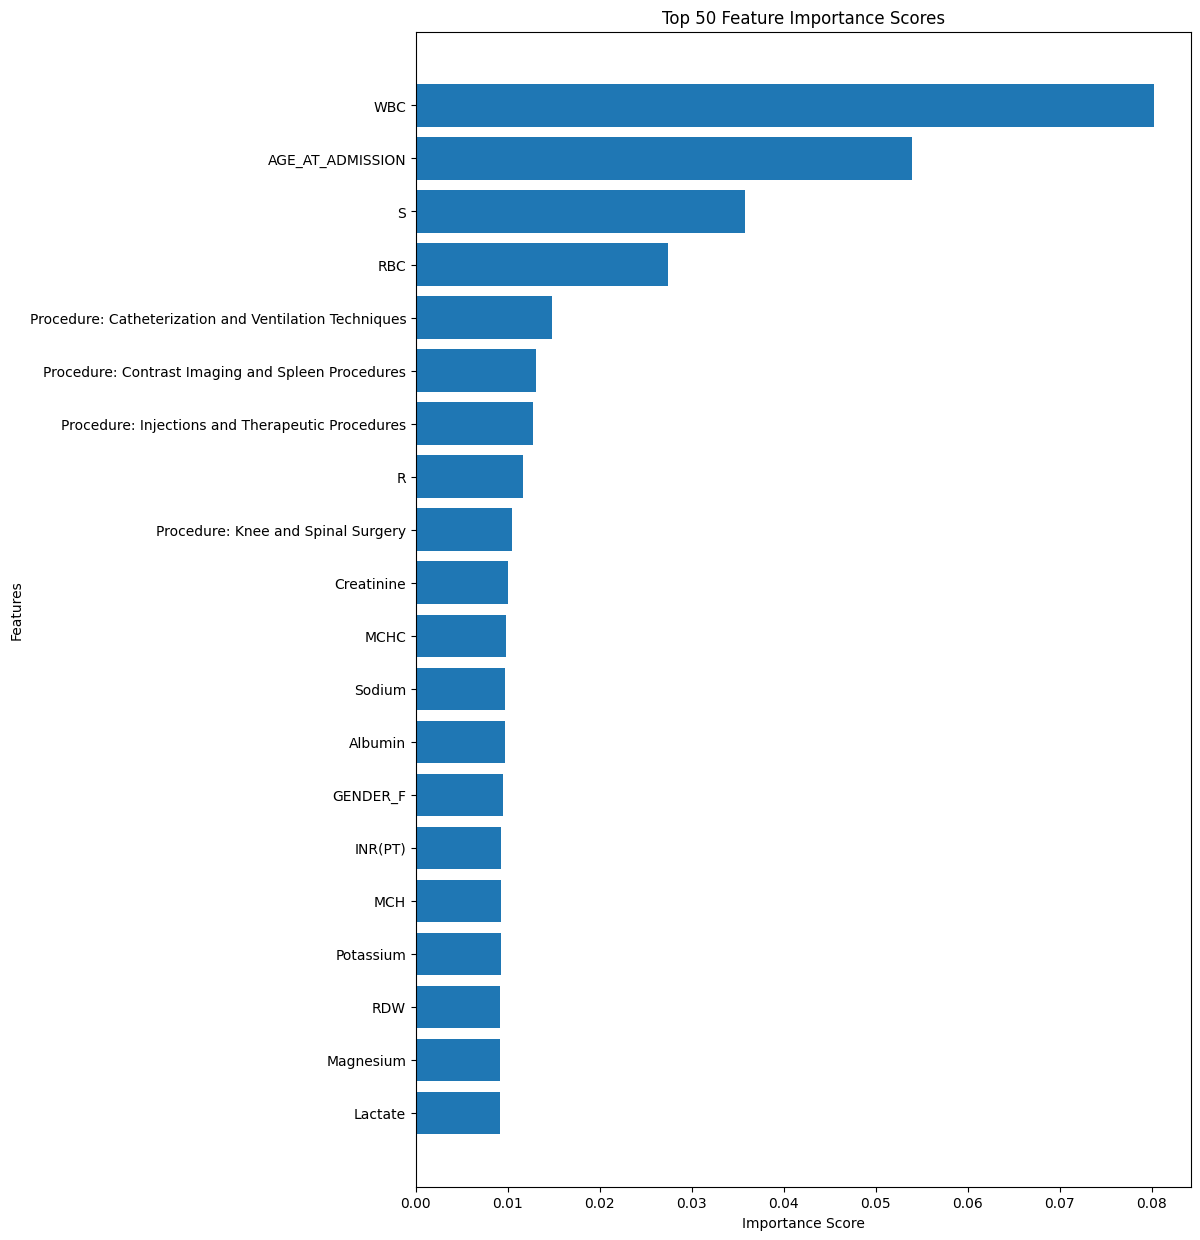

In [39]:
importances = rf.feature_importances_
features = X.columns

# Get the indices of the top features
sorted_indices = np.argsort(importances)[-20:]

plt.figure(figsize=(10,15))
plt.barh(features[sorted_indices], importances[sorted_indices])
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Top 50 Feature Importance Scores')
plt.show()


## XGBoost

In [25]:
import xgboost as xgb

# Create and train the model
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# predict using test set
xgb_predictions = xgb_model.predict(X_test_scaled)
xgb_train_predictions = xgb_model.predict(X_train_scaled)

# show classification report
print("XGBoost Classification Report:\n")
print(classification_report(y_test, xgb_predictions))

XGBoost Classification Report:

              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94     10463
         1.0       0.52      0.25      0.34      1333

    accuracy                           0.89     11796
   macro avg       0.71      0.61      0.64     11796
weighted avg       0.87      0.89      0.87     11796



In [26]:
# calculate balanced accuracy
from sklearn.metrics import balanced_accuracy_score
print(f"{balanced_accuracy_score(y_test, xgb_predictions.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, xgb_train_predictions.round()) * 100:.2f}% - Balanced accuracy Train")

60.97% - Balanced accuracy Test
77.79% - Balanced accuracy Train


Text(33.22222222222222, 0.5, 'Actual')

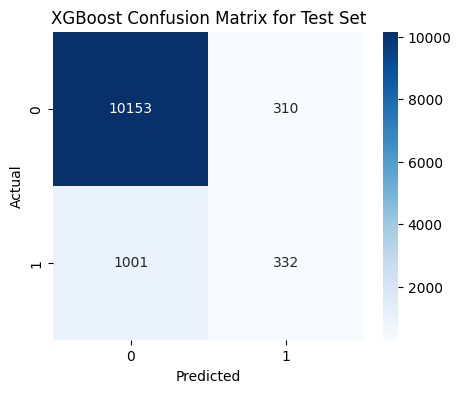

In [27]:
# define labels
labels = ['0', '1']

# confusion matrix
test_cm = confusion_matrix(y_test, xgb_predictions.round())
train_cm = confusion_matrix(y_train, xgb_train_predictions.round())
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_title('XGBoost Confusion Matrix for Test Set')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

## LightGBM

In [28]:
import lightgbm as lgb

# Create and train the model
lgb_model = lgb.LGBMClassifier(objective="binary", random_state=42)
lgb_model.fit(X_train_scaled, y_train)

# predict using test set
lgb_predictions = lgb_model.predict(X_test_scaled)
lgb_train_predictions = lgb_model.predict(X_train_scaled)

# show classification report
print("LightGBM Classification Report:\n")
print(classification_report(y_test, lgb_predictions))

[LightGBM] [Info] Number of positive: 4167, number of negative: 33577
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 37744, number of used features: 150
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.110402 -> initscore=-2.086645
[LightGBM] [Info] Start training from score -2.086645
LightGBM Classification Report:

              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94     10463
         1.0       0.59      0.20      0.30      1333

    accuracy                           0.89     11796
   macro avg       0.75      0.59      0.62     11796
weighted avg       0.87      0.89      0.87     11796



In [29]:
# calculate balanced accuracy
from sklearn.metrics import balanced_accuracy_score
print(f"{balanced_accuracy_score(y_test, lgb_predictions.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, lgb_train_predictions.round()) * 100:.2f}% - Balanced accuracy Train")

59.00% - Balanced accuracy Test
66.04% - Balanced accuracy Train


Text(33.22222222222222, 0.5, 'Actual')

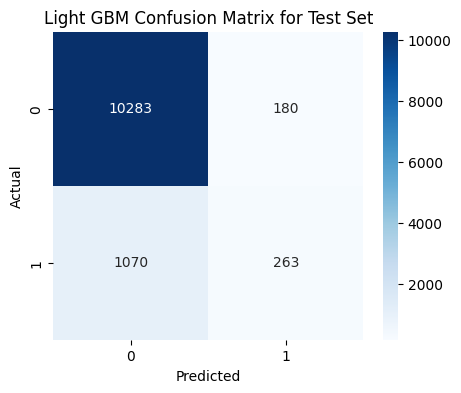

In [30]:
# define labels
labels = ['0', '1']

# confusion matrix
test_cm = confusion_matrix(y_test, lgb_predictions.round())
train_cm = confusion_matrix(y_train, lgb_train_predictions.round())
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_title('Light GBM Confusion Matrix for Test Set')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

## Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Create and train the model with balanced class weights and increased iterations
logistic_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
logistic_model.fit(X_train_scaled, y_train)

# Predict using test set
logistic_predictions = logistic_model.predict(X_test_scaled)
logistic_train_predictions = logistic_model.predict(X_train_scaled)

# Show classification report
print("Logistic Regression Classification Report:\n")
print(classification_report(y_test, logistic_predictions))


Logistic Regression Classification Report:

              precision    recall  f1-score   support

         0.0       0.97      0.80      0.88     10463
         1.0       0.34      0.79      0.48      1333

    accuracy                           0.80     11796
   macro avg       0.65      0.80      0.68     11796
weighted avg       0.90      0.80      0.83     11796



In [32]:
# calculate balanced accuracy
from sklearn.metrics import balanced_accuracy_score
print(f"{balanced_accuracy_score(y_test, logistic_predictions.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, logistic_train_predictions.round()) * 100:.2f}% - Balanced accuracy Train")

79.73% - Balanced accuracy Test
79.93% - Balanced accuracy Train


Text(33.22222222222222, 0.5, 'Actual')

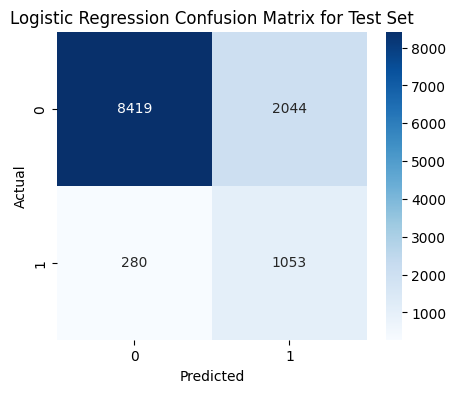

In [33]:
# define labels
labels = ['0', '1']

# confusion matrix
test_cm = confusion_matrix(y_test, logistic_predictions.round())
train_cm = confusion_matrix(y_train, logistic_train_predictions.round())
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_title('Logistic Regression Confusion Matrix for Test Set')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

**SHAP (SHapley Additive exPlanations)**

Explain the output of machine learning models and identifying feature importance by using Shapley values to fairly allocate contributions of each feature for individual predictions.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


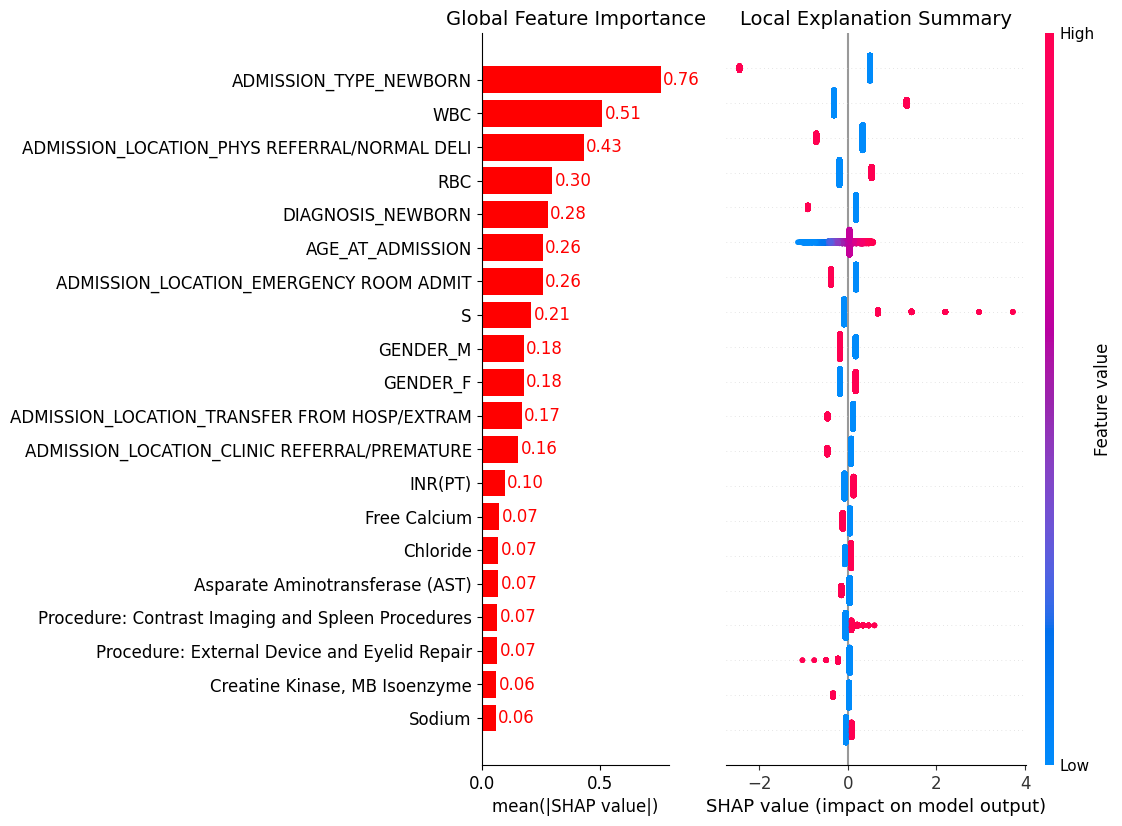

In [34]:
import matplotlib.gridspec as gridspec

# Get feature names
feature_names = X.columns.tolist()

# # Convert training and test sets to DataFrames with those feature names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

# Initialize the explainer object with the appropriate masker
masker = shap.maskers.Independent(data=X_train_scaled)
explainer = shap.LinearExplainer(logistic_model, masker=masker)

# Compute SHAP values for a particular set (e.g., test set)
shap_values_obj = explainer(X_test_scaled)

# Extract values from the Explanation object
shap_values_array = shap_values_obj.values

# Calculate mean absolute SHAP values for global importance
global_shap_vals = np.abs(shap_values_array).mean(axis=0)

# Sort features based on their global importance
sorted_indices = np.argsort(global_shap_vals)[-20:]
top_features = np.array(feature_names)[sorted_indices]
top_global_shap_vals = global_shap_vals[sorted_indices]

# Subset the data and SHAP values for top features
top_shap_values = shap_values_array[:, sorted_indices]
X_test_top_features = X_test_scaled[top_features]

# Plot global importance of top features on left
ax1 = plt.subplot(gs[0])
bars = ax1.barh(top_features, top_global_shap_vals, color='red')
ax1.set_xlabel('mean(|SHAP value|)', fontsize=12)  # Adjust font size
ax1.set_title('Global Feature Importance', fontsize=14)  # Adjust font size
ax1.tick_params(axis='both', which='major', labelsize=12)  # Adjust tick font size

# Remove the top and right spines
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# Add values beside the bar
for bar in bars:
    ax1.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.2f}',
             va='center', ha='left', color='red', fontsize=12)  # Adjust font size

# Plot typical SHAP values on right using only the top features
ax2 = plt.subplot(gs[1])
shap.summary_plot(top_shap_values, X_test_top_features, feature_names=top_features, plot_type="dot", show=False)
ax2.set_title('Local Explanation Summary', fontsize=14)  # Add title and adjust font size
ax2.tick_params(axis='both', which='major', labelsize=12)  # Adjust tick font size

# Turn off y-axis ticks and labels for ax2 (SHAP dot plot)
ax2.set_yticks([])
ax2.set_yticklabels([])

plt.show()

Red: Feature has a high value for that observation

Blue: Feature has a low value for that observation

Position on the x-axis: Indicates the effect of that value on the output


Feature importance based on SHAP-values. On the left side, the mean absolute SHAP values are depicted, to illustrate global feature importance. On the right side, the local explanation summary shows the direction of the relationship between a variable and target output. Positive SHAP-values are indicative of uti, while negative SHAP-values are indicative of non-uti. As demonstrated by the colorbar, higher values are shown in red, while lower values are shown in blue.

## ROC Curve for all models

369/369 [==============================] - 1s 1ms/step


X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names


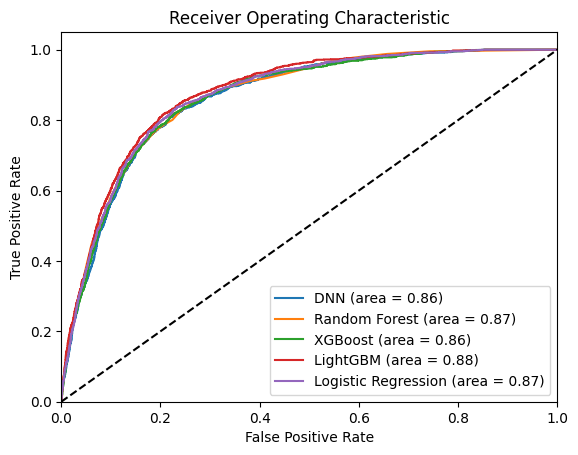

In [35]:
from sklearn.metrics import roc_curve, auc

# For DNN
y_pred_dnn = model.predict(X_test_scaled).ravel()
fpr_dnn, tpr_dnn, thresholds_dnn = roc_curve(y_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)

# For Random Forest
y_pred_rf = rf.predict_proba(X_test_scaled)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# For XGBoost
y_pred_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# For LightGBM
y_pred_lgb = lgb_model.predict_proba(X_test_scaled)[:, 1]
fpr_lgb, tpr_lgb, thresholds_lgb = roc_curve(y_test, y_pred_lgb)
roc_auc_lgb = auc(fpr_lgb, tpr_lgb)

# For Logistic Regression
y_pred_logistic = logistic_model.predict_proba(X_test_scaled)[:, 1]
fpr_logistic, tpr_logistic, thresholds_logistic = roc_curve(y_test, y_pred_logistic)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)

# Plotting
plt.figure()
plt.plot(fpr_dnn, tpr_dnn, label=f'DNN (area = {roc_auc_dnn:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (area = {roc_auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (area = {roc_auc_xgb:.2f})')
plt.plot(fpr_lgb, tpr_lgb, label=f'LightGBM (area = {roc_auc_lgb:.2f})')
plt.plot(fpr_logistic, tpr_logistic, label=f'Logistic Regression (area = {roc_auc_logistic:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
